In [289]:
from threading import Thread
from agents.bfilter import BayesFilter
from agents.utils import hierarchical_sort, str2arr
from agents.plot_hist import plot_hist

import json
import numpy as np
import pickle as pkl
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
from multiprocessing import Pool, Queue
from tqdm import tqdm, tqdm_notebook, tnrange

In [91]:
# set filenames
# data we're standardizing on (from the one-hots)
standardization_f = 'resources/stripped_normalization.pkl'

# training data for kdes, this should be a dict of metrics keyed on task
training_f = 'resources/243_raw_data.pkl' 

# test data for kdes. this includes the task, metrics, and beliefs
test_f ='results/results_file_full_243_run0_90_each'



In [92]:
# load the standardization params
with open(standardization_f,'rb') as sfile:
    standard_m, standard_std = pkl.load(sfile)
    standard_m = standard_m[:-1]
    standard_std = standard_std[:-1]
print(standard_m.shape,standard_std.shape)
print(standard_m,standard_std)

(4,) (4,)
[7.02134345e+05 1.32097649e+05 2.18597774e-01 4.19621716e-01] [2.07865180e+05 5.35621885e+04 5.92860480e-02 2.26446118e-02]


In [249]:
# load the training data and parse out the overall means and stds
train_trajectories = []
train_labels = []
with open(training_f, 'rb') as trainfile:
    training_dict = pkl.load(trainfile)

train_test_set = []
new_training_dict = {}
n_left_out = 1
for label, flattened_trajectories in training_dict.items():
    label_arr = eval(label)
    if label_arr[-1] != 0:
        #training_dict.pop(label)
        continue
    short_label = str(label_arr[:-1])
    original_length = len(flattened_trajectories)
    pared_trajectories = deepcopy(flattened_trajectories)
    for j in range(n_left_out):
        leave_out_i = np.random.randint((len(pared_trajectories)-1)/100) # skip the last one, which could be < 100
        left_out = flattened_trajectories[leave_out_i:leave_out_i+100]
        pared_trajectories = np.delete(pared_trajectories,list(range(leave_out_i,leave_out_i+100)),0)
        train_test_set.append((left_out[:,:-1],short_label))
    new_training_dict[short_label] = pared_trajectories
    assert len(new_training_dict[short_label]) + n_left_out*100 == original_length
training_dict = new_training_dict
for label,steps in training_dict.items():
    steps = steps[:,:-1]
    training_dict[label] = steps
    print(label, steps.shape)
    extra = len(steps) % 100 # since we only use this to test with, lop off the extra
    # if id didn't divide evenly, lop off extra
    # and reshape to be in steps of 100
    if extra > 0:
        chunks = steps[:-extra,:].reshape(len(steps)//100,100,4)
    else:
        chunks = steps.reshape(len(steps)//100,100,4)
    for i in range(chunks.shape[0]):
        train_trajectories.append(chunks[i,:,:])
        train_labels.append(label)
        

all_training_data = np.concatenate([v for v in training_dict.values()])
    
train_m = np.mean(all_training_data,0)
train_std = np.std(all_training_data,0)
print(train_m.shape,train_std.shape)
print(train_m,train_std)

[0.0, 0.0, 1.0, 1.0] (7646, 4)
[1.0, 1.0, 1.0, -1.0] (7337, 4)
[-1.0, 1.0, -1.0, 0.0] (8879, 4)
[-1.0, -1.0, 0.0, 1.0] (8224, 4)
[0.0, 1.0, 1.0, 1.0] (7680, 4)
[0.0, -1.0, -1.0, 0.0] (7317, 4)
[0.0, 0.0, 1.0, -1.0] (7534, 4)
[-1.0, 1.0, -1.0, -1.0] (8475, 4)
[0.0, 0.0, -1.0, 0.0] (6957, 4)
[-1.0, 1.0, 0.0, 1.0] (8591, 4)
[0.0, 1.0, -1.0, 1.0] (8323, 4)
[-1.0, 0.0, -1.0, 0.0] (9080, 4)
[1.0, 0.0, -1.0, 0.0] (8551, 4)
[1.0, 1.0, 1.0, 0.0] (7854, 4)
[-1.0, 0.0, 1.0, 0.0] (8126, 4)
[1.0, 1.0, 0.0, 1.0] (8359, 4)
[1.0, 0.0, -1.0, -1.0] (8301, 4)
[1.0, -1.0, 1.0, -1.0] (7567, 4)
[-1.0, -1.0, 1.0, 0.0] (7884, 4)
[1.0, 1.0, 0.0, -1.0] (8030, 4)
[-1.0, 0.0, -1.0, -1.0] (8481, 4)
[0.0, 0.0, -1.0, -1.0] (8201, 4)
[1.0, 0.0, 0.0, 0.0] (8423, 4)
[0.0, -1.0, 0.0, 1.0] (8114, 4)
[0.0, 0.0, 0.0, 0.0] (6558, 4)
[1.0, 0.0, 0.0, 1.0] (8172, 4)
[0.0, -1.0, 1.0, -1.0] (7542, 4)
[-1.0, 1.0, 1.0, -1.0] (6972, 4)
[1.0, 0.0, -1.0, 1.0] (8392, 4)
[0.0, 1.0, 1.0, 0.0] (6672, 4)
[1.0, -1.0, 0.0, 1.0] (8188, 4)
[0

In [332]:
pca = PCA(n_components=3)
pca.fit(metric_standardize(all_training_data,standard_m,standard_std))

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [333]:
pca.explained_variance_ratio_

array([0.35348834, 0.280618  , 0.27239048])

In [313]:
metric_standardize(train_test_set[0][0], standard_m, standard_std)[:10]

array([[ 1.0205735 , -0.22782208,  0.86084666, -0.27424303],
       [ 1.02875367, -0.22782208,  1.21091874, -0.4665861 ],
       [ 1.15230986, -0.34364073,  1.15360239, -0.30964544],
       [ 1.15252488, -0.34364073,  1.15360239, -0.2964096 ],
       [ 1.03843034, -0.22782208,  1.21091874, -0.16216404],
       [ 1.02816922, -0.22782208,  1.21091874, -0.13269043],
       [ 1.0255701 , -0.22782208,  1.21091874, -0.55496466],
       [ 1.14401595, -0.34364073,  1.11221529, -0.40434819],
       [ 1.14427498, -0.34364073,  1.11221529, -0.39507009],
       [ 1.142781  , -0.34364073,  1.21091874, -0.39500494]])

In [334]:
pca.transform(metric_standardize(train_test_set[0][0], standard_m, standard_std))[:10]

array([[ 1.02996415, -0.58508566, -0.24292824],
       [ 1.41424085, -0.55785767, -0.25001765],
       [ 1.3387463 , -0.70766806, -0.16805643],
       [ 1.33418515, -0.70692269, -0.15781398],
       [ 1.31057123, -0.54249722, -0.01625509],
       [ 1.29760817, -0.53678978,  0.01066669],
       [ 1.44423999, -0.562176  , -0.31773926],
       [ 1.33237089, -0.71545858, -0.25602458],
       [ 1.32920189, -0.7149769 , -0.24888627],
       [ 1.41761493, -0.70247749, -0.20707452]])

In [293]:
# transformed_training_dict = {}
# for task,trajectories in training_dict.items():
#     transformed_trajectories = []
#     for trajectory in trajectories:
#         transformed_trajectory = []
#         for step in trajectory:
#             transformed_step = pca.transform(step)
#             transformed_trajectory.append(transforemed_step)
#         transformed_trajectories.append(transformed_trajectory)
#     transformed_training_dict[task] = np.array(transformed_trajectories)

ValueError: Expected 2D array, got scalar array instead:
array=783459.2726262164.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [4]:
steps[:-0,:].shape

(0, 4)

In [5]:
all_test_data = []
all_test_data_append = all_test_data.append
with open(test_f, 'r') as testfile:
    for row in testfile:
        result = json.loads(row)
        metrics = result['metrics']
        # metrics is a list of observations over each 100 steps
        for m in metrics:
            all_test_data_append(m[:-1])
all_test_data = np.array(all_test_data)
test_m = np.mean(all_test_data,0)
test_std = np.std(all_test_data,0)
print(test_m.shape,test_std.shape)
print(test_m,test_std)

(4,) (4,)
[6.97818515e+05 1.26980738e+05 2.21070745e-01 4.19481711e-01] [2.45247594e+05 5.27317480e+04 5.44752682e-02 2.00649051e-02]


In [15]:
test_trajectories = []
test_labels = []
test_dict = {}
with open(test_f, 'r') as testfile:
    counter = 0
    for row in testfile:
        result = json.loads(row)
        metrics = result['metrics']
        label_arr = result['task']
        if label_arr[-1] != 0:
            continue
        short_label_arr = result['task'][:-1]
        raw_label = str(list(map(float,short_label_arr)))
        label = str(np.array(short_label_arr, dtype=float))
        metrics = [m[:-1] for m in metrics]
        test_trajectories.append(metrics)
        test_labels.append(label)
        if raw_label in test_dict:
            test_dict[raw_label] += metrics[:]
        else:
            test_dict[raw_label] = metrics[:]

test_test_set = []
for label, flattened_trajectories in test_dict.items():
    original_length = len(flattened_trajectories)
    leave_out_i = np.random.randint((len(flattened_trajectories)-1)/100) # skip the last one, which could be < 100
    left_out = flattened_trajectories[leave_out_i:leave_out_i+100]
    test_dict[label] = np.delete(flattened_trajectories,list(range(leave_out_i,leave_out_i+100)),0)
    test_test_set.append((left_out,label))
    assert len(test_dict[label]) + 100 == original_length


In [16]:
#NOTE: the train trajectories take out the test sample before creating trajectories, this does not
test_trajectories = np.array(test_trajectories)
# for i in range(len(test_labels)):
#     test_labels[i] = str(np.array(test_labels[i], dtype=float))
print(test_trajectories.shape, len(test_labels))

(4885, 100, 4) 4885


In [9]:
len(train_test_set)

243

In [12]:
combined_train_test_dict = {}
for key in training_dict.keys():
    combined_train_test_dict[key] = np.concatenate([training_dict[key],test_dict[key]])
    assert combined_train_test_dict[key].shape[-1] == 5
    print(combined_train_test_dict[key].shape)
    

(14258, 5)
(14750, 5)
(13146, 5)
(13469, 5)
(13537, 5)
(14022, 5)
(14376, 5)
(15279, 5)
(12967, 5)
(13554, 5)
(13160, 5)
(14128, 5)
(12565, 5)
(14338, 5)
(13148, 5)
(14272, 5)
(13195, 5)
(14510, 5)
(14224, 5)
(13504, 5)
(13753, 5)
(13978, 5)
(12880, 5)
(12765, 5)
(13800, 5)
(12875, 5)
(13227, 5)
(13417, 5)
(12800, 5)
(14361, 5)
(14522, 5)
(15369, 5)
(13477, 5)
(13234, 5)
(13415, 5)
(15152, 5)
(14162, 5)
(15027, 5)
(14362, 5)
(13733, 5)
(13555, 5)
(15075, 5)
(12705, 5)
(13818, 5)
(12957, 5)
(14691, 5)
(13504, 5)
(13823, 5)
(14078, 5)
(15024, 5)
(14334, 5)
(15280, 5)
(14351, 5)
(14054, 5)
(13746, 5)
(14700, 5)
(14782, 5)
(14327, 5)
(13686, 5)
(14037, 5)
(15038, 5)
(14475, 5)
(14526, 5)
(14659, 5)
(14301, 5)
(15029, 5)
(13721, 5)
(13454, 5)
(13267, 5)
(13746, 5)
(13884, 5)
(13932, 5)
(13686, 5)
(14016, 5)
(14204, 5)
(14030, 5)
(13328, 5)
(14967, 5)
(14602, 5)
(14358, 5)
(14481, 5)
(14201, 5)
(15095, 5)
(13216, 5)
(14323, 5)
(15068, 5)
(13186, 5)
(12891, 5)
(14314, 5)
(14624, 5)
(12896, 5)

In [45]:
with open('test_data.pkl','wb+') as outfile:
    pkl.dump((test_trajectories,test_labels),outfile)

In [354]:
def metric_standardize(data, m, std, transform=None):
    data = np.array(data)
    if transform is not None:
        if len(data.shape) < 2:
            return pca.transform([(data - m)/std])[0]
        else:
            return pca.transform((data - m)/std)
    else:
        return (data - m)/std
#     if len(data.shape) > 1:
#         # print(data[:,0].reshape(len(data),1).shape)
#         # print(data[:,2:].shape)
#         #trunc_data = np.concatenate((data[:,:3],data[:,4:]),1)
#         #trunc_data = np.concatenate((data[:,:1],data[:,2:]),1)
#         trunc_data = data[:,:-1]
#         assert data.shape[1] == 5
#     else:
#         #trunc_data = np.concatenate((data[:1],data[2:]))
#         trunc_data = data[:-1]
#         assert data.shape[0] == 5
# #     mean = np.concatenate((m[:1],m[2:]))
# #     std_dev = np.concatenate((std[:1],std[2:]))
#     mean = m[:-1]
#     std_dev = std[:-1]
#     return (trunc_data - mean)/std_dev
    
#     if len(data.shape) > 1:
#         return (data[:,:-1] - m[:-1])/std[:-1]
#     else:
#         return (data[:-1] - m[:-1])/std[:-1]
    #return data
kde_dict = {}
#for task in test_dict.keys():
for task,task_data in training_dict.items():
#for task in combined_train_test_dict.keys():
    task_str = str(np.array(eval(task)))
    task_data = training_dict[str(task)]
    #task_data = test_dict[str(task)]
    #task_data = combined_train_test_dict[str(task)]
    task_data = metric_standardize(task_data, standard_m, standard_std, transform=None)
    task_kde = KernelDensity(kernel = 'gaussian', bandwidth=0.1).fit(task_data)
    kde_dict[task_str] = task_kde #task_obs_fun

# generate tasks
tasks = list(map(np.array,itertools.product([-1., 0., 1.], [-1., 0., 1.], [-1., 0., 1.], [-1., 0., 1.])))
# tasks = []
task_strings = {str(task): task for task in tasks}
task_strings = list(map(str2arr, task_strings))
task_strings = list(map(str, hierarchical_sort(task_strings)))
task_dict = {tstr : str2arr(tstr) for tstr in task_strings}    

task_neighborhood_size_dict = {}
for tstr in task_strings:
    task_arr = task_dict[tstr]
    num_neighbors = 0
    for metric in task_arr:
        if metric == 0:
            num_neighbors += 2
        elif metric == -1 or metric == 1:
            num_neighbors += 1
        else:
            raise ValueError("metric was not in {-1, 0, 1}")
    task_neighborhood_size_dict[tstr] = num_neighbors

zero_prob = 1/243
low_prob = 22/243
high_prob = 220/243

def t_func(task_from, task_to, action):
    t0 = task_dict[task_from]
    t1 = task_dict[task_to]
    diff = np.linalg.norm(t1-t0,1) # get the 1-norm difference (sum of abs values of elements)
    # if more than 1 away, prob is 1/243
    if diff > 1:
        return zero_prob/(243-task_neighborhood_size_dict[task_from]-1) #uniformly distribute over the non-neighbors
    elif diff == 1:
        return low_prob/(task_neighborhood_size_dict[task_from])
    elif diff == 0:
        return high_prob # only one of these
    else:
        raise(ValueError("There is something wrong with the norm, got a negative l1 norm for {} and {}".format(t0,t1)))

def o_func(observation,task):
    return np.exp(kde_dict[str(task)].score(observation.reshape(1,len(observation))))

In [20]:
str(list(map(float,result['task'])))
print([k for k in kde_dict.keys()])

['[0. 0. 1. 1.]', '[ 1.  1.  1. -1.]', '[-1.  1. -1.  0.]', '[-1. -1.  0.  1.]', '[0. 1. 1. 1.]', '[ 0. -1. -1.  0.]', '[ 0.  0.  1. -1.]', '[-1.  1. -1. -1.]', '[ 0.  0. -1.  0.]', '[-1.  1.  0.  1.]', '[ 0.  1. -1.  1.]', '[-1.  0. -1.  0.]', '[ 1.  0. -1.  0.]', '[1. 1. 1. 0.]', '[-1.  0.  1.  0.]', '[1. 1. 0. 1.]', '[ 1.  0. -1. -1.]', '[ 1. -1.  1. -1.]', '[-1. -1.  1.  0.]', '[ 1.  1.  0. -1.]', '[-1.  0. -1. -1.]', '[ 0.  0. -1. -1.]', '[1. 0. 0. 0.]', '[ 0. -1.  0.  1.]', '[0. 0. 0. 0.]', '[1. 0. 0. 1.]', '[ 0. -1.  1. -1.]', '[-1.  1.  1. -1.]', '[ 1.  0. -1.  1.]', '[0. 1. 1. 0.]', '[ 1. -1.  0.  1.]', '[ 0.  0. -1.  1.]', '[ 0.  0.  0. -1.]', '[ 1.  0.  0. -1.]', '[-1.  1.  0. -1.]', '[ 1. -1.  1.  0.]', '[-1. -1.  0. -1.]', '[-1.  0.  1. -1.]', '[ 1. -1.  0. -1.]', '[ 0.  1. -1. -1.]', '[ 0. -1.  0. -1.]', '[ 0.  1.  0. -1.]', '[-1. -1.  0.  0.]', '[-1. -1. -1.  1.]', '[ 0.  1. -1.  0.]', '[ 1.  1. -1. -1.]', '[-1.  0.  0.  0.]', '[-1.  0.  1.  1.]', '[-1. -1. -1.  0.]', '[

In [83]:
str2arr(task_strings[0])

array([1., 1., 1., 1., 1.])

In [ ]:
b = BayesFilter(task_strings,t_func,o_func)

In [324]:
# Results queue
RESULTS_QUEUE = Queue()
# Status queue
STATUS_QUEUE = Queue() 
from copy import deepcopy
def filter_trajectory(trajectory_tuples):
    # tuples are (trajectory, label)
    trajectory, label = trajectory_tuples
    print(len(trajectory))
    targets = []
    targets_append = targets.append
    predictions = []
    predictions_append = predictions.append
    bf = BayesFilter(task_strings,t_func,o_func)
    for step in trajectory:
        #belief_star = bf.prediction_step(action=None)
        standardized_step = metric_standardize(step, standard_m, standard_std,transform=pca)
        belief = deepcopy(bf.observation_step(standardized_step))
        prediction = max(belief, key=lambda x :belief[x])
        # get the second max instead
#         belief.pop(prediction)
#         prediction = max(belief, key=lambda x :belief[x])
#         belief.pop(prediction)
#         prediction = max(belief, key=lambda x :belief[x])
        ####
        #print("Target: {}, Prediction: {}".format(label,prediction))
        targets_append(label)
        predictions_append(prediction)
        STATUS_QUEUE.put(1)
    #RESULTS_QUEUE.put((targets, predictions))
    return targets, predictions

def progress_monitor(n_steps):
    for i in tqdm_notebook(range(n_steps)):
        STATUS_QUEUE.get()

In [22]:
task_freq = {task_str : 0 for task_str in task_strings}
num_satisfied = 0
num_each = 1
abbreviated_trajectories = []
abbreviated_labels = []
for i, label in enumerate(test_labels):
    if num_satisfied >= len(task_strings):
        break
    elif task_freq[label] >= num_each:
        if task_freq[label] == num_each:
            # only check equal to prevent retriggering (we increment each step)
            num_satisfied += 1
        # otherwise just ignore
    else:
        abbreviated_trajectories.append(test_trajectories[i])
        abbreviated_labels.append(label)
    task_freq[label] += 1
print(len(abbreviated_trajectories), len(test_trajectories))

81 4885


In [239]:
len(test_trajectories[100])

6500

In [23]:
abbreviations = list(zip(abbreviated_trajectories,abbreviated_labels))


In [167]:
input_arr = train_test_set
abbreviations_dict = {}
for trajectory,label in input_arr:
    print(label)
    abbreviations_dict[label] = []
    for step in trajectory:
        abbreviations_dict[label].append(step)
    abbreviations_dict[label] = np.array(abbreviations_dict[label])

[0.0, 0.0, 1.0, 1.0]
[1.0, 1.0, 1.0, -1.0]
[-1.0, 1.0, -1.0, 0.0]
[-1.0, -1.0, 0.0, 1.0]
[0.0, 1.0, 1.0, 1.0]
[0.0, -1.0, -1.0, 0.0]
[0.0, 0.0, 1.0, -1.0]
[-1.0, 1.0, -1.0, -1.0]
[0.0, 0.0, -1.0, 0.0]
[-1.0, 1.0, 0.0, 1.0]
[0.0, 1.0, -1.0, 1.0]
[-1.0, 0.0, -1.0, 0.0]
[1.0, 0.0, -1.0, 0.0]
[1.0, 1.0, 1.0, 0.0]
[-1.0, 0.0, 1.0, 0.0]
[1.0, 1.0, 0.0, 1.0]
[1.0, 0.0, -1.0, -1.0]
[1.0, -1.0, 1.0, -1.0]
[-1.0, -1.0, 1.0, 0.0]
[1.0, 1.0, 0.0, -1.0]
[-1.0, 0.0, -1.0, -1.0]
[0.0, 0.0, -1.0, -1.0]
[1.0, 0.0, 0.0, 0.0]
[0.0, -1.0, 0.0, 1.0]
[0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 1.0]
[0.0, -1.0, 1.0, -1.0]
[-1.0, 1.0, 1.0, -1.0]
[1.0, 0.0, -1.0, 1.0]
[0.0, 1.0, 1.0, 0.0]
[1.0, -1.0, 0.0, 1.0]
[0.0, 0.0, -1.0, 1.0]
[0.0, 0.0, 0.0, -1.0]
[1.0, 0.0, 0.0, -1.0]
[-1.0, 1.0, 0.0, -1.0]
[1.0, -1.0, 1.0, 0.0]
[-1.0, -1.0, 0.0, -1.0]
[-1.0, 0.0, 1.0, -1.0]
[1.0, -1.0, 0.0, -1.0]
[0.0, 1.0, -1.0, -1.0]
[0.0, -1.0, 0.0, -1.0]
[0.0, 1.0, 0.0, -1.0]
[-1.0, -1.0, 0.0, 0.0]
[-1.0, -1.0, -1.0, 1.0]
[0.0, 1.0, -1.0,

In [54]:
abbreviations = []
for key, trials in training_dict.items():
    choice = np.random.randint(len(trials)) // 100 * 100 # hacky way of getting to a multiple of a hundred
    if len(trials) - choice < 100:
        choice -= 100
    abbreviations.append((trials[choice:choice+100],key))

In [18]:
len(abbreviated_trajectories[0])

100

In [337]:
RESULTS_QUEUE = Queue()
STATUS_QUEUE = Queue()
#input_arr = abbreviations
input_arr = train_test_set
thread = Thread(target=progress_monitor, args=(len(input_arr)*100,))
thread.start()
print("starting")
results = None
with Pool(8) as pool:
        results = pool.map(filter_trajectory, input_arr)

starting


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


In [22]:
len(results[0])

2

In [ ]:
# # targets = []
# # predictions = []
# # targets_append = targets.append
# # predictions_append = predictions.append
# while RESULTS_QUEUE.qsize() != 0:
#     print("popping")
#     traj_targets, traj_predictions = RESULTS_QUEUE.get()
#     for t in traj_targets:
#         targets_append(t)
#     for p in traj_predictions:
#         predictions_append(p)

In [338]:
targets,predictions = zip(*results)

In [339]:
targets = np.concatenate(targets)
predictions = np.concatenate(predictions)


In [243]:
len(targets)

40500

In [365]:
targets[0:10]
#targets = [str(np.array(eval(t))) for t in targets]
targets[-10:]

['[ 1.  1. -1.  1.]',
 '[ 1.  1. -1.  1.]',
 '[ 1.  1. -1.  1.]',
 '[ 1.  1. -1.  1.]',
 '[ 1.  1. -1.  1.]',
 '[ 1.  1. -1.  1.]',
 '[ 1.  1. -1.  1.]',
 '[ 1.  1. -1.  1.]',
 '[ 1.  1. -1.  1.]',
 '[ 1.  1. -1.  1.]']

In [274]:
targets[90:100]
predictions[50:100]

array(['[1. 0. 1. 0.]', '[1. 0. 1. 0.]', '[1. 0. 1. 0.]', '[1. 0. 1. 0.]',
       '[1. 0. 1. 0.]', '[1. 0. 1. 0.]', '[1. 0. 1. 0.]', '[1. 0. 1. 0.]',
       '[1. 0. 1. 0.]', '[1. 0. 1. 0.]', '[1. 0. 1. 0.]', '[1. 0. 1. 0.]',
       '[1. 0. 1. 0.]', '[1. 0. 1. 0.]', '[1. 0. 1. 0.]', '[1. 0. 1. 0.]',
       '[1. 0. 1. 0.]', '[1. 0. 1. 0.]', '[1. 0. 1. 0.]', '[1. 0. 1. 0.]',
       '[1. 0. 1. 0.]', '[1. 0. 1. 0.]', '[1. 0. 1. 1.]', '[1. 0. 1. 1.]',
       '[1. 0. 1. 1.]', '[1. 0. 1. 1.]', '[1. 0. 1. 1.]', '[1. 0. 1. 1.]',
       '[1. 0. 1. 1.]', '[1. 0. 1. 1.]', '[1. 0. 1. 1.]', '[1. 0. 1. 1.]',
       '[1. 0. 1. 1.]', '[1. 0. 1. 1.]', '[1. 0. 1. 1.]', '[1. 0. 1. 1.]',
       '[1. 0. 1. 1.]', '[1. 0. 1. 1.]', '[1. 0. 1. 1.]', '[1. 0. 1. 1.]',
       '[1. 0. 1. 1.]', '[1. 0. 1. 1.]', '[1. 0. 1. 1.]', '[1. 0. 1. 1.]',
       '[1. 0. 1. 1.]', '[1. 0. 1. 1.]', '[1. 0. 1. 1.]', '[1. 0. 1. 1.]',
       '[1. 0. 1. 1.]', '[1. 0. 1. 1.]'], dtype='<U17')

In [ ]:
# targets = []
# predictions = []
# targets_append = targets.append
# predictions_append = predictions.append
# for i,trajectory in enumerate(test_trajectories):
#     b = BayesFilter(task_strings,t_func,o_func)
#     for step in trajectory:
#         standardized_step = metric_standardize(step, test_m, test_std)
#         belief = b.observation_step(standardized_step)
#         prediction = max(belief, key=lambda x :belief[x])
#         #print("Target: {}, Prediction: {}".format(test_labels[i],prediction))
#         targets_append(test_labels[i])
#         predictions_append(prediction)

In [341]:
simple_accuracy = sum([1 if prediction == targets[i] else 0 for i,prediction in enumerate(predictions)])
print("Simple_Accuracy: {}/{} = {}".format(simple_accuracy,len(predictions),simple_accuracy/len(predictions)))

Simple_Accuracy: 2137/8100 = 0.26382716049382715


In [342]:
cm = confusion_matrix(targets, predictions, labels=task_strings)

[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.75 0.25
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]


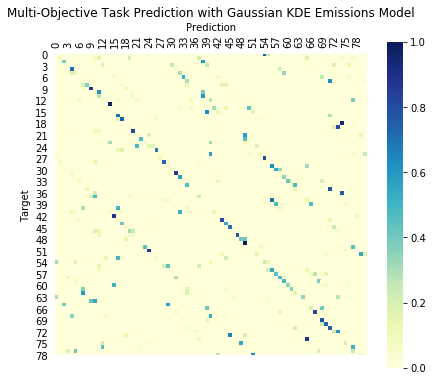

In [343]:
fig = plt.figure(figsize=(7, 6))
xmin = 0 #192
xmax = len(task_str) #218
ymin = 0 #110
ymax = len(task_str) #137
cm = cm.astype(float)
for row in range(cm.shape[0]):
    tot_freq = np.sum(cm[row, :])
    cm[row,:] = cm[row,:]/tot_freq
print(cm[0, :])
#sns.heatmap(cm, cmap='YlGnBu', square=1, annot=True, fmt="d", linewidths=1, xticklabels=task_names, yticklabels=task_names)
sns.heatmap(cm, cmap='YlGnBu', square=1)
#sns.heatmap(cm[ymin:ymax, xmin:xmax], cmap='YlGnBu', square=1, annot=False, xticklabels=task_names[xmin:xmax], yticklabels=task_names[ymin:ymax])
ax = plt.gca()
ax.xaxis.tick_top()
ax.tick_params(axis="x", rotation=90)
ax.tick_params(width=0)
ax.xaxis.set_label_position('top')
# plt.xticks(np.arange(len(task_names)), task_names, rotation=90)
#plt.xlim(0, len(task_names))
#plt.yticks(np.arange(len(task_names)), task_names, rotate=90)
#plt.ylim(len(task_names), 0)  # inverted range for "upper" origin
plt.ylabel('Target')
plt.xlabel('Prediction')
plt.title('Multi-Objective Task Prediction with Gaussian KDE Emissions Model')
plt.show()


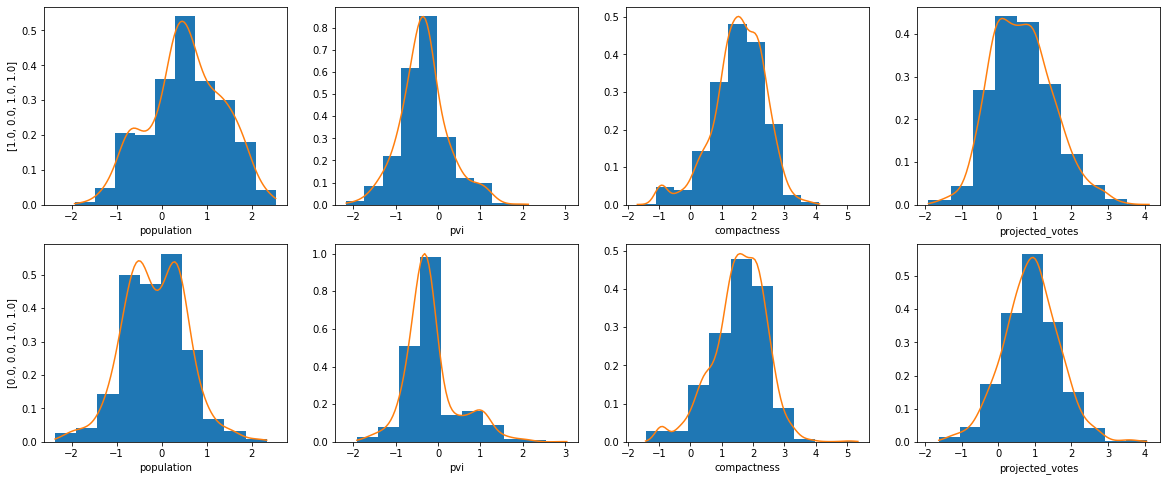

In [349]:
import agents.plot_hist
agents.plot_hist.plot_hist(training_dict,['[1.0, 0.0, 1.0, 1.0]','[0.0, 0.0, 1.0, 1.0]'], transform=None, pop_m=standard_m,pop_std=standard_std)

In [387]:
np.exp(kde_dict[str(np.array([1., 0., 0., 0.]))].score([[2,-0.5,1.1,1.1]]))

1.6534469595286814e-05

In [377]:
np.exp(kde_dict[str(np.array([0., 0., 1., 1.]))].score([[0.5,-0.5,1.1,1.1]]))

0.1498851434773772

In [347]:
import importlib
import sys
importlib.reload(sys.modules['agents.plot_hist'])

<module 'agents.plot_hist' from '/home/dev/PycharmProjects/distopia_agents/agents/plot_hist.py'>

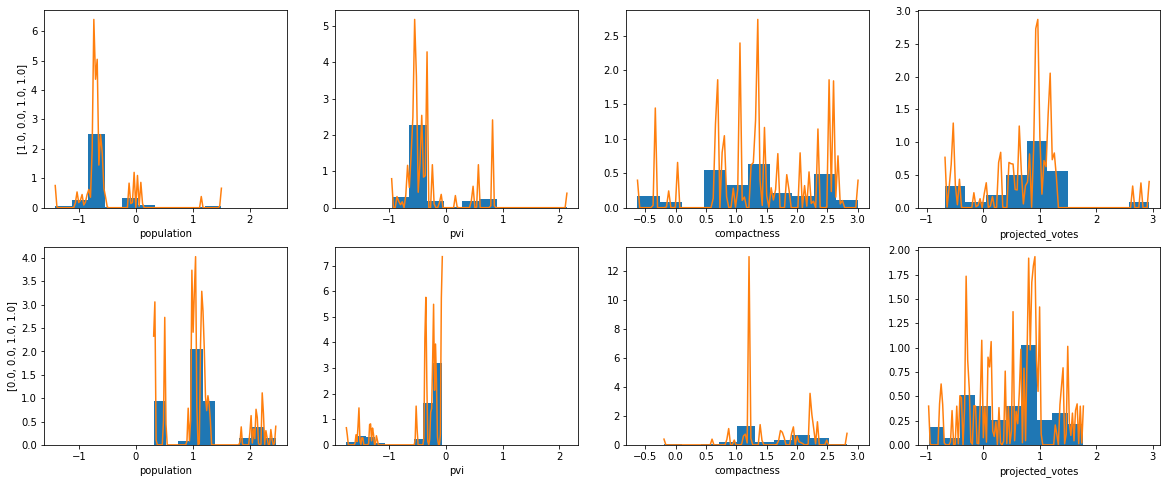

In [192]:
agents.plot_hist.plot_hist(abbreviations_dict,[str([1.0, 0.0, 1.0, 1.0]),str([0.0, 0.0, 1.0, 1.0])], pop_m=standard_m,pop_std=standard_std)